В этом ноутбуке продемонстрирован весь пайплайн работы симулятора на датасете Netflix: генерация эмбеддингов профилей пользователей, обучение моделей генерации синтетических профилей пользователей, обучение функции отклика, обучение рекомендательной системы UCB путем взаимодействия с симулятором.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from replay.session_handler import State

from sklearn.metrics import roc_auc_score, precision_score, recall_score

import pyspark.sql.functions as sf
import pyspark.ml.functions as smf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, FMClassifier
)

from replay.metrics import NDCG, Precision, RocAuc
from replay.data_preparator import Indexer
from replay.models import RandomRec
from replay.models import UCB

from sim4rec.modules import (
    SDVDataGenerator, RealDataGenerator,
    Simulator, evaluate_synthetic,
    EvaluateMetrics
)
from sim4rec.response import BernoulliResponse, ParametricResponseFunction
from sim4rec.utils import VectorElementExtractor, pandas_to_spark

from datautils import read_netflix

%matplotlib inline
import matplotlib.pyplot as plt

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'
DATA_PATH = r'file:///data/home/anthony/DL_0/real_data_simulator/Netflix'
MODELS_DIR = '../bin'

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/15 09:48:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/15 09:48:08 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
def test_model(model_class, train_data, test_data, assembler, extractor):
    model = model_class(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec', predictionCol='response')

    start = time.time()
    pipeline = Pipeline(stages=[assembler, model, extractor]).fit(train_data)
    train_time = time.time() - start

    pred_pdf = pipeline\
        .transform(test_data)\
        .select('relevance', '__prob_raw', 'item_rating_avg', 'response')\
        .toPandas()

    pred_pdf['baseline_prob'] =\
        (pred_pdf['item_rating_avg'] - pred_pdf['item_rating_avg'].min()) /\
        (pred_pdf['item_rating_avg'].max() - pred_pdf['item_rating_avg'].min())
    pred_pdf['baseline_bin'] = np.where(pred_pdf['baseline_prob'] >= 0.5, 1, 0)

    roc_auc_model = roc_auc_score(pred_pdf.relevance, pred_pdf.__prob_raw)
    roc_auc_baseline = roc_auc_score(pred_pdf.relevance, pred_pdf.baseline_prob)

    precision_model = precision_score(pred_pdf.relevance, pred_pdf.response)
    precision_baseline = precision_score(pred_pdf.relevance, pred_pdf.baseline_bin)

    recall_model = recall_score(pred_pdf.relevance, pred_pdf.response)
    recall_baseline = recall_score(pred_pdf.relevance, pred_pdf.baseline_bin)

    return train_time, pred_pdf,\
           {
            'roc_auc' : roc_auc_model,
            'precision' : precision_model,
            'recall' : recall_model
           },\
           {
            'roc_auc' : roc_auc_baseline,
            'precision' : precision_baseline,
            'recall' : recall_baseline
           }

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Netflix): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [3]:
users_df_train, items_df_train, log_df_train = read_netflix(DATA_PATH, 'train', spark)

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/15 09:49:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


50934106

In [4]:
users_df_val, items_df_val, log_df_val = read_netflix(DATA_PATH, 'val', spark)

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

24430434

In [5]:
users_df_test, items_df_test, log_df_test = read_netflix(DATA_PATH, 'test', spark)

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

25115967

# Генерация эмбеддингов

В результате экспериментального исследования методов генерации эмбеддингов (netflix_embeddings.ipynb) было решено использовать метод главных компонент в случае датасета Netflix. Далее с помощью этого метода генерируются профили пользователей.

In [6]:
pca_va = VectorAssembler(
    inputCols=['user_rating_avg', 'user_rating_cnt'] + [f'user_w2v_{i}' for i in range(300)],
    outputCol='features'
)
pca_estimator = PCA(k=10, inputCol='features', outputCol='pca_features')

pca = Pipeline(stages=[pca_va, pca_estimator]).fit(users_df_train)

22/11/15 09:53:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/15 09:53:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/15 09:53:27 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/15 09:53:27 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [7]:
users_df_train = pca.transform(users_df_train)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])

users_df_val = pca.transform(users_df_val)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])

# Обучение генератора

Также в ноутбуке netflix_embeddings.ipynb был сделан вывод о том, что модель генерации TVAE является наиболее подходящей в случае датасета Netflix и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [8]:
# user_generator = SDVDataGenerator(
#     label='synth_user',
#     id_column_name='user_id',
#     model_name='tvae',
#     parallelization_level=8,
#     device_name='cpu',
#     seed=1234
# )

# user_generator.fit(users_df_train)

user_generator = SDVDataGenerator.load(f'{MODELS_DIR}/netflix_pca_users_tvae.pkl')
user_generator.setDevice('cpu')
user_generator.setParallelizationLevel(8)

users_synth = user_generator.generate(users_df_train.count())

eval_frac = 1000 / users_df_train.count()
gen_score = evaluate_synthetic(
    synth_df=users_synth.sample(eval_frac).drop('user_id'),
    real_df=users_df_train.sample(eval_frac).drop('user_id')
)

gen_score

Cannot load model to device cuda:0. Setting cpu instead


{'LogisticDetection': 0.6365636500551264,
 'SVCDetection': 0.4776006552225289,
 'KSTest': 0.9028025667138312,
 'ContinuousKLDivergence': 0.8172246563833353}

In [9]:
item_generator = RealDataGenerator(label='real_item', seed=1234)
item_generator.fit(items_df_train)
_ = item_generator.generate(items_df_train.count())

22/11/11 12:09:21 WARN CacheManager: Asked to cache already cached data.


# Инициализация симулятора

In [10]:
simulator = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=f'{CHECKPOINT_DIR}/netflix_response'
)

# Обучение регрессии

Необходимо определить, какая модель отклика наиболее точно приближает отклик, присутствующий в исторических данных. В качестве кандидатов использованы три модели:

-- Logistic Regression;

-- Random Forest;

-- Matrix Factorization.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [8]:
feature_cols = [f'user_features[{i}]' for i in range(10)] +\
               ['item_rating_avg'] +\
               [f'item_w2v_{i}' for i in range(300)]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
extractor = VectorElementExtractor(inputCol='__prob_vec', outputCol='__prob_raw', index=1)
multiplier = ParametricResponseFunction(inputCols=['__prob_raw'], outputCol='__prob', weights=[0.25])
bernoulli = BernoulliResponse(inputCol='__prob', outputCol='response', seed=1234)

train_df = log_df_val\
    .sample(100000 / log_df_val.count())\
    .drop('timestamp')\
    .join(users_df_train, on='user_id', how='left')\
    .join(items_df_train, on='item_id', how='left')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .sample(100000 / log_df_test.count())\
    .drop('timestamp')\
    .join(users_df_val, on='user_id', how='left')\
    .join(items_df_val, on='item_id', how='left')\
    .na.drop()\
    .cache()

# Качество логистической регрессии

In [10]:
lr_time, lr_pdf, lr_model_metrics, lr_baseline_metrics = test_model(
    model_class=LogisticRegression,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

LogisticRegression pipeline train time: 48.16394853591919
LogisticRegression metrics: {'roc_auc': 0.7111957241937823, 'precision': 0.8725620823148021, 'recall': 0.99714655668521}
Baseline metrics:           {'roc_auc': 0.6696136795957677, 'precision': 0.8835787190752479, 'recall': 0.9475949549203914}


<AxesSubplot: >

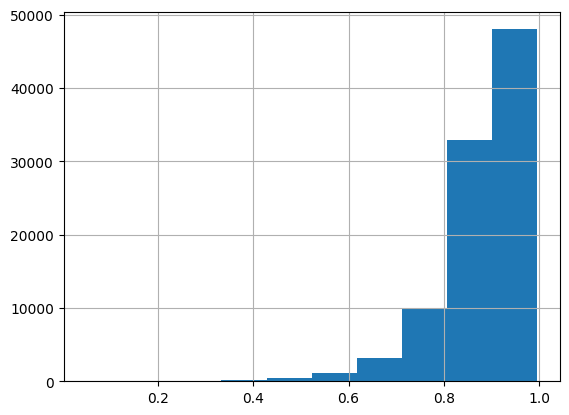

In [11]:
print(f'LogisticRegression pipeline train time: {lr_time}')
print(f'LogisticRegression metrics: {lr_model_metrics}')
print(f'Baseline metrics:           {lr_baseline_metrics}')

lr_pdf['__prob_raw'].hist()

# Качество случайного леса

In [12]:
rf_time, rf_pdf, rf_model_metrics, rf_baseline_metrics = test_model(
    model_class=RandomForestClassifier,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

RandomForestClassifier pipeline train time: 11.264264583587646
RandomForestClassifier metrics: {'roc_auc': 0.6736135630914598, 'precision': 0.8695579649708091, 'recall': 1.0}
Baseline metrics:               {'roc_auc': 0.6696136795957677, 'precision': 0.8835787190752479, 'recall': 0.9475949549203914}


<AxesSubplot: >

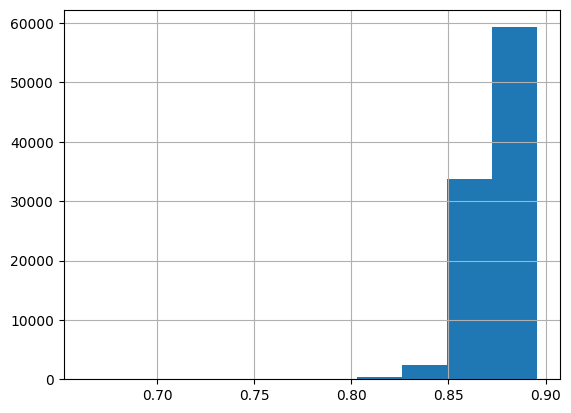

In [13]:
print(f'RandomForestClassifier pipeline train time: {rf_time}')
print(f'RandomForestClassifier metrics: {rf_model_metrics}')
print(f'Baseline metrics:               {rf_baseline_metrics}')

rf_pdf['__prob_raw'].hist()

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [18]:
lr = LogisticRegression(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec')
pipeline = Pipeline(stages=[assembler, lr, extractor, multiplier, bernoulli]).fit(train_df)

В качестве бейзлайна будем использовать рекомендательную систему, которая предлагает пользователю случайные предложения.

In [19]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_generator.sample(1.0), items=items_df_test)

dummy_log = pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]}))

ucb = UCB(sample=True)
ucb.fit(indexer.transform(dummy_log))

random_rec = RandomRec(distribution='uniform')
random_rec.fit(indexer.transform(dummy_log))

22/11/11 12:14:54 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/11/11 12:14:55 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/11/11 12:14:56 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/11/11 12:15:01 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/11/11 12:15:01 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/11/11 12:15:02 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


In [20]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [ ]:
user_frac = 10000 / user_generator.getDataSize()
item_frac = 2000 / item_generator.getDataSize()

random_rec_simulator = Simulator(None, None, f'{CHECKPOINT_DIR}/netflix_response_rnd', None, 'user_id', 'item_id', spark)

ucb_metrics = []
rnd_metrics = []
for i in range(100):
    iter_start = time.time()

    users = simulator.sample_users(user_frac).cache()
    items = simulator.sample_items(item_frac).cache()
    log = simulator.get_log(users)
    log = dummy_log if log is None else log
    log = log.cache()

    recs_ucb = ucb.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items),
        filter_seen_items=False
    )
    recs_ucb = indexer.inverse_transform(recs_ucb).cache()
    recs_rnd = random_rec.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items),
        filter_seen_items=False
    )
    recs_rnd = indexer.inverse_transform(recs_rnd).cache()

    resp_ucb = simulator.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    resp_rnd = simulator.sample_responses(
        recs_df=recs_rnd,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    simulator.update_log(resp_ucb, iteration=i)
    random_rec_simulator.update_log(resp_rnd, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))
    rnd_metrics.append(evaluator(resp_rnd))

    ucb._clear_cache()
    ucb_train_log = simulator.log.cache()
    ucb.fit(log=indexer.transform(
        ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('response', 'relevance')
    ))

    random_rec._clear_cache()
    rnd_train_log = random_rec_simulator.log.cache()
    random_rec.fit(log=indexer.transform(
        rnd_train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')\
                     .filter(sf.col('relevance') == 1)
    ))

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    recs_rnd.unpersist()
    resp_ucb.unpersist()
    resp_rnd.unpersist()
    ucb_train_log.unpersist()
    rnd_train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_start} sec.')

22/11/11 12:16:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:16:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:16:19 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:16:20 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:16:22 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:16:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:16:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/11 12:16:33 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:16:37 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:16:38 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:16:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:16:47 WARN DAGScheduler: Broadc

Iteration 0 finished in 138.49869751930237 sec.


22/11/11 12:18:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:18:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:18:35 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:18:37 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:18:38 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:18:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:18:47 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:18:48 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:18:51 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:18:52 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:18:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:19:00 WARN DAGScheduler: Broadc

Iteration 1 finished in 130.12956309318542 sec.


22/11/11 12:20:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:20:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:20:47 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:20:49 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:20:51 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:20:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:20:59 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:21:00 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:21:03 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:21:04 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:21:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:21:12 WARN DAGScheduler: Broadc

Iteration 2 finished in 133.3047971725464 sec.


22/11/11 12:22:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:22:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:22:56 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:22:57 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:22:58 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:23:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:23:07 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:23:08 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:23:11 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:23:12 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:23:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:23:21 WARN DAGScheduler: Broadc

Iteration 3 finished in 130.27756929397583 sec.


22/11/11 12:25:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:25:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:25:06 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:25:07 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:25:09 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:25:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:25:18 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:25:18 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:25:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:25:23 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:25:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:25:31 WARN DAGScheduler: Broadc

Iteration 4 finished in 128.0215449333191 sec.


22/11/11 12:27:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:27:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:27:13 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:27:14 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:27:16 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:27:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:27:25 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:27:26 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:27:29 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:27:30 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:27:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:27:38 WARN DAGScheduler: Broadc

Iteration 5 finished in 130.26815819740295 sec.


22/11/11 12:29:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:29:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:29:27 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:29:28 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:29:29 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:29:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:29:38 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:29:38 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:29:42 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:29:43 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:29:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:29:52 WARN DAGScheduler: Broadc

Iteration 6 finished in 130.87359046936035 sec.


22/11/11 12:31:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:31:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:31:42 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:31:44 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:31:45 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:31:54 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:31:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:31:55 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:31:58 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:32:00 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:32:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:32:09 WARN DAGScheduler: Broadc

Iteration 7 finished in 142.45954489707947 sec.


22/11/11 12:33:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:33:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:34:01 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:34:02 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:34:03 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:34:12 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:34:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:34:14 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:34:27 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:34:28 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:34:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:34:39 WARN DAGScheduler: Broadc

Iteration 8 finished in 150.19155263900757 sec.


22/11/11 12:36:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:36:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:36:33 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:36:35 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:36:36 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:36:44 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:36:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:36:45 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:36:48 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:36:50 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:36:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:36:57 WARN DAGScheduler: Broadc

Iteration 9 finished in 136.27757382392883 sec.


22/11/11 12:38:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:38:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:38:46 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:38:47 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:38:49 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:38:58 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:38:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:38:59 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:39:02 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:39:03 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:39:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:39:12 WARN DAGScheduler: Broadc

Iteration 10 finished in 135.49125123023987 sec.


22/11/11 12:40:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:40:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:41:03 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:41:04 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:41:06 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:41:14 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:41:19 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:41:20 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:41:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:41:29 WARN DAGScheduler: Broadc

Iteration 11 finished in 137.32478022575378 sec.


22/11/11 12:43:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:43:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:43:17 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:43:18 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:43:20 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:43:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:43:29 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:43:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:43:34 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:43:35 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:43:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:43:44 WARN DAGScheduler: Broadc

Iteration 12 finished in 135.35119152069092 sec.


22/11/11 12:45:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:45:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:45:36 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:45:38 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:45:40 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:45:48 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:45:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:45:49 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:45:54 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:45:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:46:02 WARN DAGScheduler: Broadc

Iteration 13 finished in 138.2699625492096 sec.


22/11/11 12:47:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:47:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:47:53 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:47:54 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:47:56 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:48:04 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:48:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:48:05 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:48:08 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:48:10 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:48:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:48:18 WARN DAGScheduler: Broadc

Iteration 14 finished in 134.7328395843506 sec.


22/11/11 12:50:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:50:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:50:10 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:50:11 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:50:13 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:50:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:50:23 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:50:26 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:50:27 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:50:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:50:36 WARN DAGScheduler: Broadc

Iteration 15 finished in 139.82418155670166 sec.


22/11/11 12:52:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:52:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:52:31 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:52:33 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:52:34 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:52:42 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:52:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:52:44 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:52:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:52:48 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:52:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:52:57 WARN DAGScheduler: Broadc

Iteration 16 finished in 142.33988404273987 sec.


22/11/11 12:54:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:54:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:54:53 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:54:55 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:54:56 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:55:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:55:05 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:55:06 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:55:09 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:55:10 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:55:11 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:55:18 WARN DAGScheduler: Broadc

Iteration 17 finished in 141.51814317703247 sec.


22/11/11 12:57:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:57:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:57:17 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:57:18 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 12:57:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:57:31 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:57:32 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:57:33 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:57:40 WARN DAGScheduler: Broadc

Iteration 18 finished in 142.16049456596375 sec.


22/11/11 12:59:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:59:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:59:31 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 12:59:32 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 12:59:34 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:59:44 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 12:59:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:59:48 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 12:59:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 12:59:57 WARN DAGScheduler: Broadc

Iteration 19 finished in 136.56179332733154 sec.


22/11/11 13:01:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:01:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:01:54 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:01:56 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:01:58 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:02:07 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:02:10 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:02:11 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:02:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:02:20 WARN DAGScheduler: Broadc

Iteration 20 finished in 143.43372774124146 sec.


22/11/11 13:04:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:04:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:04:34 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:04:36 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:04:38 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:04:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:04:50 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:04:51 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:04:55 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:04:57 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:04:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:05:08 WARN DAGScheduler: Broadc

Iteration 21 finished in 172.82772517204285 sec.


22/11/11 13:07:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:07:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:07:06 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:07:08 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:07:09 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:07:17 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:07:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:07:18 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:07:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:07:23 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:07:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:07:31 WARN DAGScheduler: Broadc

Iteration 22 finished in 140.89141988754272 sec.


22/11/11 13:09:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:09:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:09:28 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:09:30 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:09:32 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:09:40 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:09:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:09:45 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:09:46 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:09:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:09:55 WARN DAGScheduler: Broadc

Iteration 23 finished in 142.91205835342407 sec.


22/11/11 13:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:11:58 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:12:00 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:12:01 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:12:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:12:10 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:12:11 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:12:14 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:12:16 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:12:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:12:24 WARN DAGScheduler: Broadc

Iteration 24 finished in 151.09209871292114 sec.


22/11/11 13:14:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:14:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:14:29 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:14:30 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:14:32 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:14:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:14:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:14:42 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:14:46 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:14:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:14:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:14:56 WARN DAGScheduler: Broadc

Iteration 25 finished in 150.28691840171814 sec.


22/11/11 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:17:06 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:17:08 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:17:09 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:17:18 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:17:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:17:19 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:17:23 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:17:24 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:17:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:17:32 WARN DAGScheduler: Broadc

Iteration 26 finished in 157.14746475219727 sec.


22/11/11 13:19:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:19:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:19:29 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:19:31 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:19:33 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:19:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:19:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:19:42 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:19:46 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:19:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:19:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:19:56 WARN DAGScheduler: Broadc

Iteration 27 finished in 145.9503893852234 sec.


22/11/11 13:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:21:57 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:21:58 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:22:00 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:22:08 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:22:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:22:09 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:22:12 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:22:13 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:22:21 WARN DAGScheduler: Broadc

Iteration 28 finished in 143.8473677635193 sec.


22/11/11 13:24:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:24:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:24:19 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:24:20 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:24:22 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:24:31 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:24:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:24:32 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:24:36 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:24:37 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:24:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:24:46 WARN DAGScheduler: Broadc

Iteration 29 finished in 144.8708209991455 sec.


22/11/11 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:26:51 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:26:52 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:26:54 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:27:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:27:02 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:27:03 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:27:06 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:27:08 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:27:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:27:16 WARN DAGScheduler: Broadc

Iteration 30 finished in 150.4049563407898 sec.


22/11/11 13:29:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:29:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:29:18 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:29:20 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:29:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:29:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:29:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:29:31 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:29:35 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:29:36 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:29:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:29:44 WARN DAGScheduler: Broadc

Iteration 31 finished in 148.31642317771912 sec.


22/11/11 13:31:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:31:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:31:40 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:31:42 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:31:43 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:31:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:31:51 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:31:52 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:31:56 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:31:57 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:31:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:32:05 WARN DAGScheduler: Broadc

Iteration 32 finished in 142.90884923934937 sec.


22/11/11 13:34:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:34:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:34:07 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:34:08 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:34:10 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:34:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:34:35 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:34:36 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:34:40 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:34:42 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:34:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:34:54 WARN DAGScheduler: Broadc

Iteration 33 finished in 172.99174737930298 sec.


22/11/11 13:36:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:36:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:36:55 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:36:56 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:36:58 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:37:06 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:37:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:37:07 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:37:11 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:37:12 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:37:21 WARN DAGScheduler: Broadc

Iteration 34 finished in 146.00781869888306 sec.


22/11/11 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:39:28 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:39:30 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:39:31 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:39:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:39:40 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:39:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:39:44 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:39:46 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:39:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:39:54 WARN DAGScheduler: Broadc

Iteration 35 finished in 152.36009740829468 sec.


22/11/11 13:41:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:41:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:42:00 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:42:01 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:42:03 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:42:11 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:42:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:42:12 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:42:17 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:42:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:42:25 WARN DAGScheduler: Broadc

Iteration 36 finished in 153.0214672088623 sec.


22/11/11 13:44:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:44:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:44:30 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:44:31 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:44:33 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:44:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:44:42 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:44:43 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:44:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:44:48 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:44:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:44:56 WARN DAGScheduler: Broadc

Iteration 37 finished in 150.13430976867676 sec.


22/11/11 13:46:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:46:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:47:01 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:47:02 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:47:04 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:47:12 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:47:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:47:13 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:47:17 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:47:18 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:47:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:47:26 WARN DAGScheduler: Broadc

Iteration 38 finished in 150.87486100196838 sec.


22/11/11 13:49:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:49:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:49:31 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:49:33 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:49:35 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:49:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:49:43 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:49:44 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:49:48 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:49:50 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:49:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:49:58 WARN DAGScheduler: Broadc

Iteration 39 finished in 154.1710159778595 sec.


22/11/11 13:52:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:52:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:52:05 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:52:06 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:52:08 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:52:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:52:16 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:52:17 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:52:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:52:22 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:52:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:52:30 WARN DAGScheduler: Broadc

Iteration 40 finished in 150.34377026557922 sec.


22/11/11 13:54:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:54:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:54:34 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:54:36 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:54:37 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:54:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:54:45 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:54:46 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:54:50 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:54:51 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:54:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:54:59 WARN DAGScheduler: Broadc

Iteration 41 finished in 148.41237139701843 sec.


22/11/11 13:57:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:57:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:57:10 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 13:57:11 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:57:19 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:57:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:57:20 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:57:24 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:57:25 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 13:57:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 13:57:33 WARN DAGScheduler: Broadc

Iteration 42 finished in 155.57101249694824 sec.


22/11/11 13:59:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:59:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:59:45 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:59:47 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 13:59:48 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 13:59:57 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 13:59:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 13:59:58 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:00:02 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:00:03 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:00:04 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:00:11 WARN DAGScheduler: Broadc

Iteration 43 finished in 157.52404689788818 sec.


22/11/11 14:02:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:02:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:02:18 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:02:20 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:02:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:02:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:02:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:02:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:02:34 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:02:35 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:02:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:02:43 WARN DAGScheduler: Broadc

Iteration 44 finished in 153.16862964630127 sec.


22/11/11 14:05:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:05:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:05:13 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:05:15 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:05:16 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:05:26 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:05:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:05:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:05:35 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:05:36 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:05:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:05:46 WARN DAGScheduler: Broadc

Iteration 45 finished in 186.06139636039734 sec.


22/11/11 14:07:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:07:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:08:04 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:08:05 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:08:07 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:08:16 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:08:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:08:17 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:08:20 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:08:21 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:08:30 WARN DAGScheduler: Broadc

Iteration 46 finished in 161.2101411819458 sec.


22/11/11 14:10:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:10:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:10:43 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:10:44 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:10:46 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:10:54 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:10:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:10:59 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:11:00 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:11:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:11:08 WARN DAGScheduler: Broadc

Iteration 47 finished in 160.89194869995117 sec.


22/11/11 14:13:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:13:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:13:22 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:13:24 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:13:32 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:13:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:13:33 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:13:36 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:13:38 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:13:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:13:46 WARN DAGScheduler: Broadc

Iteration 48 finished in 155.4462730884552 sec.


22/11/11 14:15:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:15:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:15:52 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:15:53 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:15:55 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:16:02 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:16:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:16:04 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:16:07 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:16:08 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:16:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:16:17 WARN DAGScheduler: Broadc

Iteration 49 finished in 152.7877218723297 sec.


22/11/11 14:18:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:18:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:18:28 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:18:30 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:18:31 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:18:40 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:18:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:18:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:18:44 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:18:45 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:18:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:18:54 WARN DAGScheduler: Broadc

Iteration 50 finished in 156.307475566864 sec.


22/11/11 14:21:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:21:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:21:08 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:21:10 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:21:11 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:21:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:21:20 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:21:20 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:21:24 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:21:25 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:21:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:21:33 WARN DAGScheduler: Broadc

Iteration 51 finished in 159.75158166885376 sec.


22/11/11 14:23:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:23:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:23:49 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:23:50 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:23:52 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:24:02 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:24:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:24:03 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:24:08 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:24:10 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:24:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:24:20 WARN DAGScheduler: Broadc

Iteration 52 finished in 168.93642449378967 sec.


22/11/11 14:26:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:26:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:26:48 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:26:50 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:26:52 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:27:02 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:27:06 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:27:07 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:27:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:27:16 WARN DAGScheduler: Broadc

Iteration 53 finished in 177.73666501045227 sec.


22/11/11 14:29:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:29:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:29:35 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:29:36 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:29:38 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:29:47 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:29:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:29:48 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:29:51 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:29:52 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:29:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:30:01 WARN DAGScheduler: Broadc

Iteration 54 finished in 163.6070830821991 sec.


22/11/11 14:32:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:32:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:32:19 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:32:20 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:32:22 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:32:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:32:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:32:32 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:32:35 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:32:36 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:32:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:32:45 WARN DAGScheduler: Broadc

Iteration 55 finished in 165.11433291435242 sec.


22/11/11 14:35:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:35:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:35:13 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/11/11 14:35:14 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB
22/11/11 14:35:16 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/11/11 14:35:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/11 14:35:27 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:35:28 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/11/11 14:35:31 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:35:33 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/11/11 14:35:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/11/11 14:35:42 WARN DAGScheduler: Broadc

Iteration 56 finished in 176.6416015625 sec.


(0.5, 0.7)

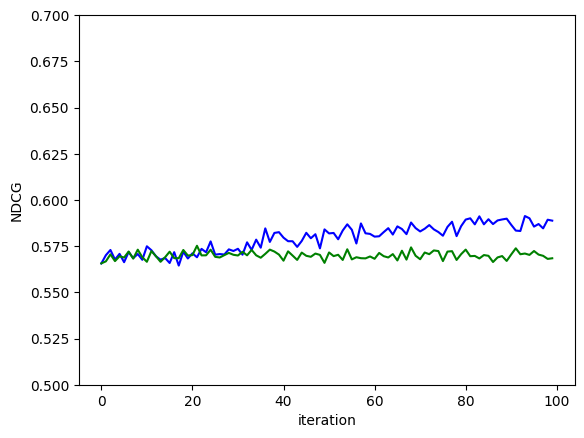

In [25]:
ucb_metrics_pdf = pd.DataFrame(ucb_metrics)
rnd_metrics_pdf = pd.DataFrame(rnd_metrics)

plt.plot(ucb_metrics_pdf['NDCG@10'], color='b')
plt.plot(rnd_metrics_pdf['NDCG@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.5, 0.7)

(0.2, 0.3)

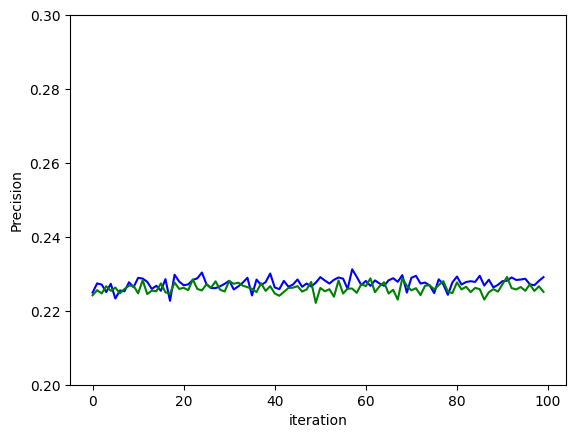

In [26]:
plt.plot(ucb_metrics_pdf['Precision@10'], color='b')
plt.plot(rnd_metrics_pdf['Precision@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('Precision')
plt.ylim(0.2, 0.3)

(0.4, 0.6)

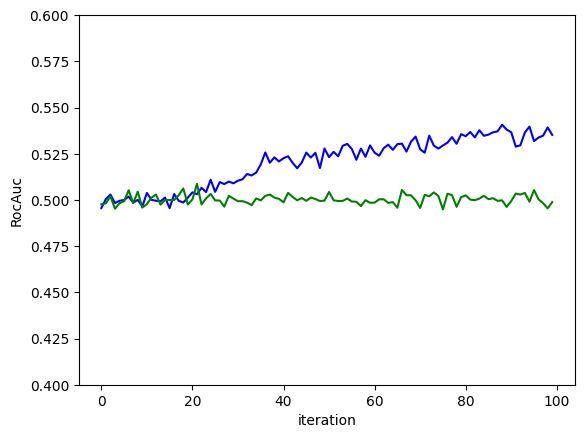

In [27]:
plt.plot(ucb_metrics_pdf['RocAuc@10'], color='b')
plt.plot(rnd_metrics_pdf['RocAuc@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('RocAuc')
plt.ylim(0.4, 0.6)